# Intraday Strategy Using GARCH
* Uses Simulated daily and 5-min data.
* Load and clean the data
* Run GARCH multiple times to find the best paramteters using AIC and BIC
* Fit the best model and define a function to predict volatiltiy for daily data
* Calculate prediction premium and generate a signal based on it
* Merge this with intraday data and calculate intraday factors to generate intraday signals
* Generate position entry and hold
* Calcualte strategy returns

## 1. Load data
* Import packages and data

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
import os
import pandas_ta

In [105]:
folder_path = '' #enter absolute path of folder containing data file 
daily_data = pd.read_csv(os.path.join(folder_path,'simulated_daily_data.csv'))
daily_data['log-ret'] = np.log(daily_data['Adj Close']).diff()
daily_data['Date'] = pd.to_datetime(daily_data['Date']).dt.date
daily_data = daily_data.set_index('Date')

intraday_data = pd.read_csv(os.path.join(folder_path,'simulated_5min_data.csv'))
intraday_data['datetime'] = pd.to_datetime(intraday_data['datetime'])
intraday_data['date'] =  intraday_data['datetime'].dt.date
intraday_data.set_index('datetime')


,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


## 2. Brute Force Garch to find the best parameters using AIC and BIC

In [106]:
daily_data = daily_data.dropna()
def evaluate_model(p,q):
    am = arch_model(y=daily_data['log-ret'], vol='GARCH', p=p, q=q)
    res = am.fit(disp='off')

    aic, bic = res.aic, res.bic

    residuals = (daily_data['log-ret'] - res.conditional_volatility)/res.conditional_volatility
    backtest = (residuals**2).sum()

    return aic, bic, backtest


In [107]:
p_list = [1,2,3,4,5]
q_list = [1,2,3,4,5]

best_p , best_q = None, None

lowest_aic, lowest_bic = 1e6, 1e6


for p in p_list:
    for q in q_list:
        aic, bic, backtest = evaluate_model(p,q)
        if aic<lowest_aic and bic<lowest_bic:
            lowest_bic = bic
            lowest_aic = aic
            best_p = p
            best_q = q
        print(f'P: {p} \t Q: {q}')
        print(f'AIC: {aic}')
        print(f'BIC: {bic}')
        print(f'Backtest: {backtest}')
        print()

print(f'Best P: {best_p}')
print(f'Best Q: {best_q}')


c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univa

P: 1 	 Q: 1
AIC: -12734.336983366768
BIC: -12709.944844342062
Backtest: 6761.023365895001

P: 1 	 Q: 2
AIC: -12753.272755370901
BIC: -12722.782581590021
Backtest: 6562.062872161595

P: 1 	 Q: 3
AIC: -12816.588651775774
BIC: -12780.000443238718
Backtest: 6347.2040933070975

P: 1 	 Q: 4
AIC: -12814.58864810664
BIC: -12771.902404813409
Backtest: 6347.245159270119

P: 1 	 Q: 5
AIC: -12812.588652693215
BIC: -12763.804374643807
Backtest: 6347.209033042898

P: 2 	 Q: 1
AIC: -12725.651490695804
BIC: -12695.161316914924
Backtest: 6617.996668013771

P: 2 	 Q: 2
AIC: -12794.456012980729
BIC: -12757.867804443673
Backtest: 6344.218688205299

P: 2 	 Q: 3
AIC: -12814.962511531592
BIC: -12772.27626823836
Backtest: 6346.466816056112

P: 2 	 Q: 4
AIC: -12812.962513583177
BIC: -12764.17823553377
Backtest: 6346.489003187729

P: 2 	 Q: 5
AIC: -12745.0769365232
BIC: -12690.194623717616
Backtest: 6349.369684609646

P: 3 	 Q: 1
AIC: -12739.38011107807
BIC: -12702.791902541014
Backtest: 6558.584001755373

P: 3

c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univa

P: 3 	 Q: 5
AIC: -12810.524757205778
BIC: -12749.544409644017
Backtest: 6346.9200711562025

P: 4 	 Q: 1
AIC: -12812.841966149363
BIC: -12770.15572285613
Backtest: 6342.215683609718

P: 4 	 Q: 2
AIC: -12830.420004363741
BIC: -12781.635726314333
Backtest: 6340.09567778943

P: 4 	 Q: 3
AIC: -12774.290809657567
BIC: -12719.408496851982
Backtest: 6132.523111609287

P: 4 	 Q: 4
AIC: -12753.058236058987
BIC: -12692.077888497226
Backtest: 6394.607466013278

P: 4 	 Q: 5
AIC: -12745.48466075604
BIC: -12678.406278438102
Backtest: 6356.498345119548

P: 5 	 Q: 1
AIC: -12810.84196736508
BIC: -12762.057689315672
Backtest: 6342.218615672742



c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univa

P: 5 	 Q: 2
AIC: -12828.556370019825
BIC: -12773.67405721424
Backtest: 6339.786207664785

P: 5 	 Q: 3
AIC: -12825.438152188834
BIC: -12764.457804627073
Backtest: 6344.36367938884

P: 5 	 Q: 4
AIC: -12834.780904701553
BIC: -12767.702522383615
Backtest: 6342.267148238211

P: 5 	 Q: 5
AIC: -12720.344545638185
BIC: -12647.168128564072
Backtest: 6382.89527893746

Best P: 4
Best Q: 2


c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univa

# 3. Forecasting Time using a rolling window variance of 252

In [108]:
daily_data['Variance'] = daily_data['log-ret'].rolling(252).var()

def predict_volatility(y):
    res = arch_model(p=best_p, q=best_q, y=y).fit(disp='off')
    
    variance_forecast = res.forecast(horizon=1).variance.iloc[-1,0]
    return variance_forecast

daily_data['Predictions'] = daily_data['log-ret'].rolling(252).apply(lambda x: predict_volatility(x))
daily_data


c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001551. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00153. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ronan\anaconda3\envs\dam\Lib\site-packages\arch\univar

,Open,High,Low,Close,Adj Close,Volume,log-ret,Variance,Predictions
Date,,,,,,,,,
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,-0.074643,NaN,NaN
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,-0.072402,NaN,NaN
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,0.035111,NaN,NaN
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,-0.024968,NaN,NaN
2014-09-22,99.775002,101.728996,99.282501,100.538002,100.538002,2.412760e+07,0.008317,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000548,0.000397
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000548,0.000309
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000548,0.000302


<Axes: xlabel='Date'>

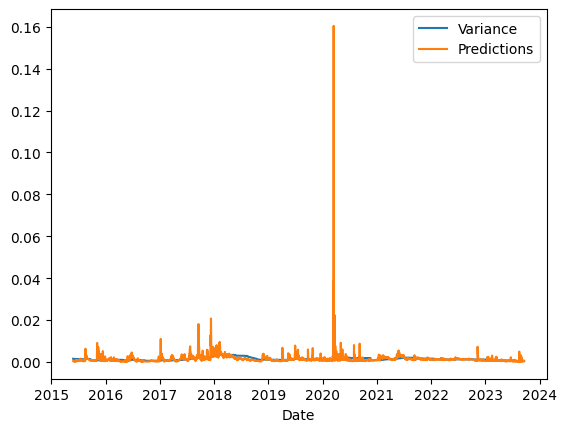

In [109]:
daily_data[['Variance', 'Predictions']].plot()



# 4 Calculate Prediction Premium
* as the title says and calc its 1 year rolling std
* use this to create a daily signal

<Axes: ylabel='Frequency'>

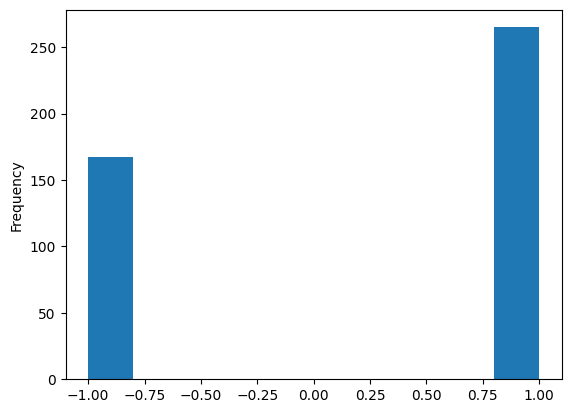

In [110]:
daily_data['Prediction-Premium'] = (daily_data['Predictions'] - daily_data['Variance'])/daily_data['Variance']
daily_data['Premium-std'] = daily_data['Prediction-Premium'].rolling(252).std()
daily_data['Signal'] = daily_data.apply(lambda x: 1 if x['Prediction-Premium'] > x['Premium-std'] else\
                                         (-1 if x['Prediction-Premium']<x['Premium-std']*-1 else np.nan), axis=1)
daily_data['Signal'] = daily_data['Signal'].shift()
daily_data['Signal'].plot(kind='hist')

# 5 Merge with Intraday data and calculate intraday indicators to form the intraday signal.


In [122]:
final_df = intraday_data.merge(daily_data[['Date', 'Signal']], left_on=['date'], right_on=['Date']).set_index('datetime')
final_df = final_df.drop(columns=['Date', 'date'], axis=1)

final_df['MACD'] = pandas_ta.macd(close=final_df['close']).iloc[0:,1]
final_df['RSI'] = pandas_ta.rsi(close=final_df['close'])
final_df['Intraday-Signal'] = final_df.apply(lambda x: 1 if (x['RSI'] > 70 and x['MACD'] >0)\
                                             else(-1 if (x['RSI']<30 and x['MACD']<0) else np.nan), axis =1)
final_df


,open,low,high,close,volume,Signal,RSI,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,Intraday-Signal,Return-Sign,Return,Forward-Return,Strat-Return,MACD
datetime,,,,,,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,0.001270,NaN,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001270,0.005605,NaN,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005605,-0.000146,NaN,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000146,-0.000813,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,67.626988,6677.365065,6696.61025,6715.855435,NaN,NaN,0.000128,0.000070,NaN,0.807916
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,68.036603,6679.544207,6698.05200,6716.559793,NaN,NaN,0.000070,-0.000158,NaN,0.782592
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,65.997545,6682.379916,6699.45700,6716.534084,NaN,NaN,-0.000158,-0.000368,NaN,0.611886


# 6 Generate Entry Positions

In [125]:
final_df['Return-Sign'] = final_df.apply(lambda x: 1 if x['Signal'] == -1 and x['Intraday-Signal']== -1 else\
                                         (-1 if x['Signal'] == 1 and x['Intraday-Signal'] == 1 else np.nan), axis=1)


final_df['Return'] = final_df['close'].pct_change()
final_df['Forward-Return'] = final_df['Return'].shift(-1)
final_df['Strat-Return'] = final_df['Forward-Return']*final_df['Return-Sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))[['Strat-Return']].sum()

# 7 Calculate Final Strat Returns

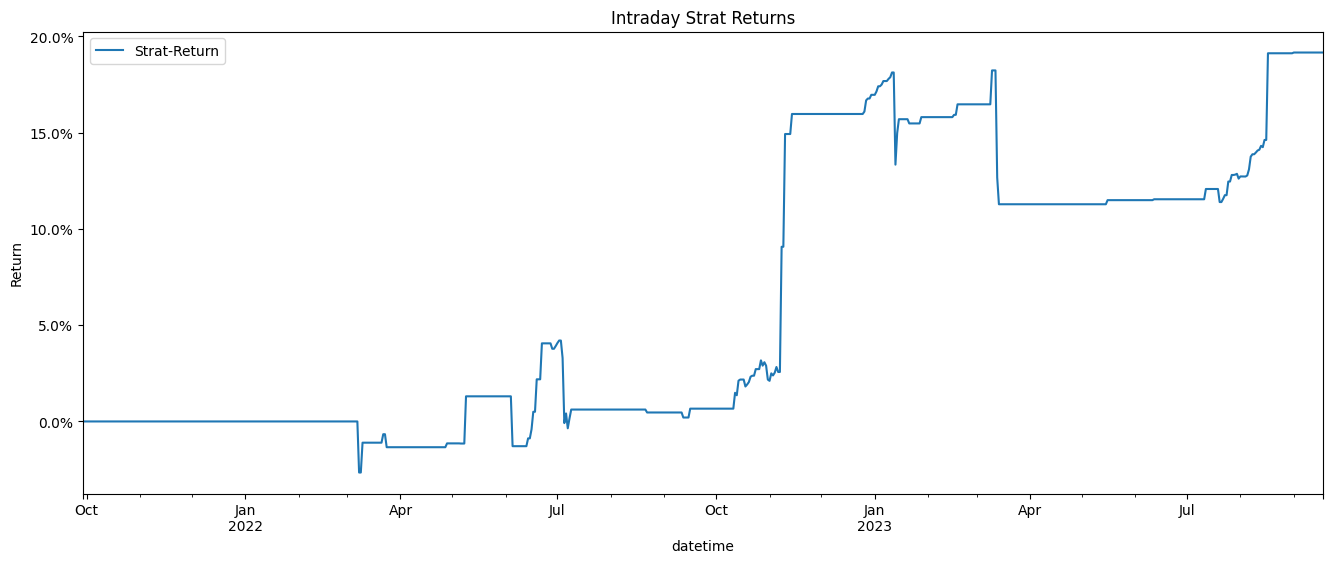

In [126]:
import matplotlib.ticker as mtick
strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)
strategy_cumulative_return.plot(figsize=(16,6))
plt.title('Intraday Strat Returns')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

<Axes: xlabel='datetime'>

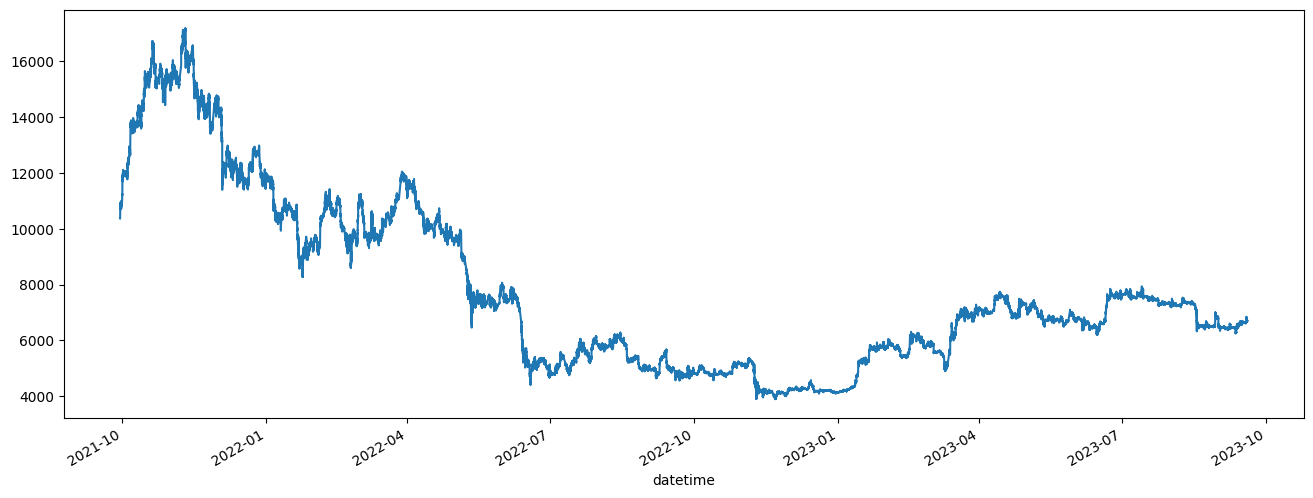

In [128]:
final_df['close'].plot(figsize=(16,6))